
# Stalker Challenge (Data Scientist)Challenge

Use the dataset here: https://snap.stanford.edu/data/loc-gowalla.html

- Assume a “stalker” is someone who, in this dataset, visits some of the same locations as another person, after the other person goes to that location.

- A “stalker score” for a pair of people, A & B, is the number of locations for which A has visited a location followed by B visiting that same location in the future.

- Any given location should be counted once in the score, so a stalker score can never be higher than the number of unique locations that A and B have in common.

Use the datasets from the web page above to answer the following questions:

- Which friend pair has the highest “stalker score”?
- Which non-friend pair has the highest “stalker score”?

You can use any tools you want to solve this puzzle, except asking for help from other people. Please feel free to email at any time for any clarifications.

Please give the winning user id pairs and “stalker score” for each question, and please explain your solution methods, including any source code if you wrote any.

## Data Exploration and data reduction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib notebook

In [2]:
# import records table
columns = ['user', 'check-in time', 'location id']
table = pd.read_table('Gowalla_totalCheckins.txt', usecols=[0, 1, 4], names=columns)

In [3]:
# Import friendship table
edges = pd.read_table('Gowalla_edges.txt', names=['source', 'target'])

In [4]:
l_loc = len(table['location id'].unique())
l_us = len(table.user.unique())
print(f'Unique locations in table: {l_loc}')
print(f'Unique users in table: {l_us}')

Unique locations in table: 1280969
Unique users in table: 107092


From the unique users count, We can infer that a brute force algorithm that behaves like $\mathcal{O}(n^{2})$,
will take $1x10^{10}$ exploration calculations to get the highest friend and no-friend scores.

Let us do more explorations in the data to find any patterm that allows us to reduce the exploration. 
- Filter users that appear just 1 time.
- Filter locations that appear just 1 time.
- Look for users with multiple locations, not with multiple visits to the same location.

We can plot the distributions of users count and locations visited by users.

In [5]:
user_count = table.user.value_counts() # unique user count
loc_count = table['location id'].value_counts() # unique location count

Now we are going to get the count of unique locations visited by user  

In [6]:
user_locations = table.groupby(['user', 'location id']).size().reset_index(name='counts')
user_locations = user_locations.user.value_counts()

<IPython.core.display.Javascript object>


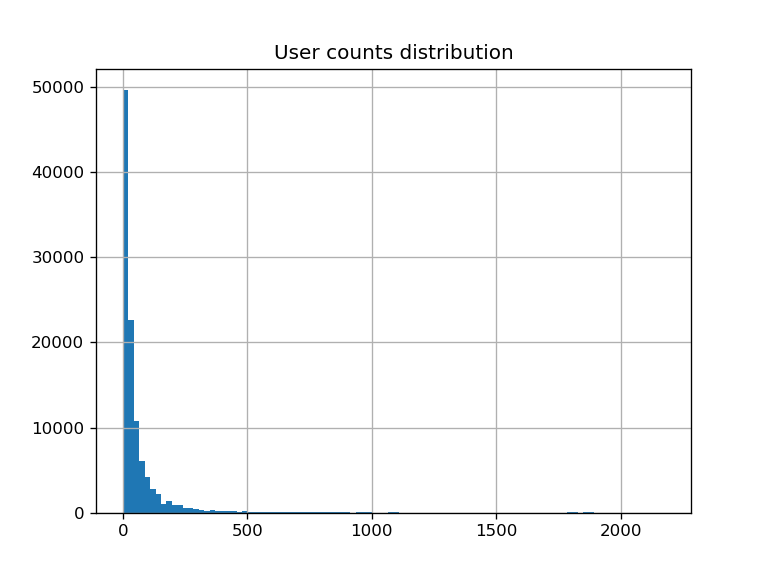

In [7]:
user_count.hist(bins=100)
plt.title('User counts distribution')
plt.show()

<IPython.core.display.Javascript object>


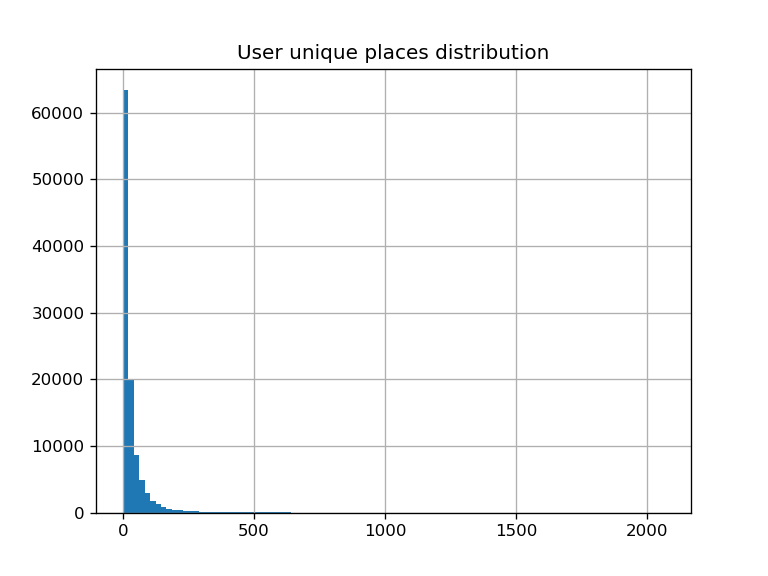

In [8]:
user_locations.hist(bins=100)
plt.title('User unique places distribution')
plt.show()

Both disgtributions look like a Power-law, lets check it for user unique places distribution

In [11]:
bins = pd.cut(user_locations, bins=100, retbins=False).value_counts(normalize=True)

<IPython.core.display.Javascript object>


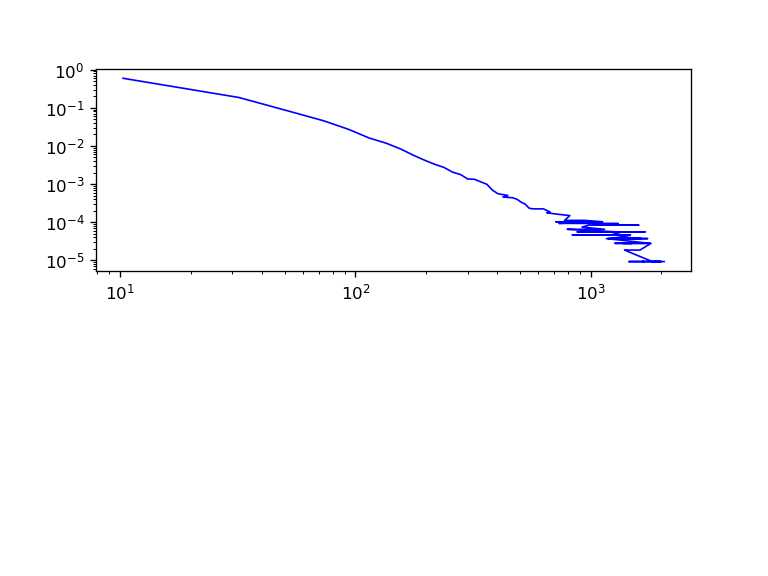

In [87]:
plt.subplot(2,1,1)
plt.plot([x.mid for x in bins.index], bins.values, color='blue', lw=1)
plt.yscale('log')
plt.xscale('log')
plt.show()

With a linear regression we can get the slope, which is $\alpha$ for a Power-law:

$$ p(x)=\frac{\alpha - 1}{x_{min}}\left(\frac{x}{x_{min}}\right)^{-\alpha} $$

In [62]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress([x.mid for x in bins.index], bins.values)

In [63]:
print(f'alpha = {-slope}')

alpha = 2.8016615230630652e-05


The user locations distribution is similar to a wealth distribution and gini index, which allow to find things like 
the 80-20 "rule", that comes from the equation:

$$ W = P^{(\alpha-2)/(\alpha-1)}$$

In the case os 80-20 "rule", 80% of wealth is just hold by 20% of people. With this we can find the percentage of users to explore to find the highest scores.

Plotting $W$ vs $P$ for $\alpha= 2.8 x 10^{-5}$

<IPython.core.display.Javascript object>


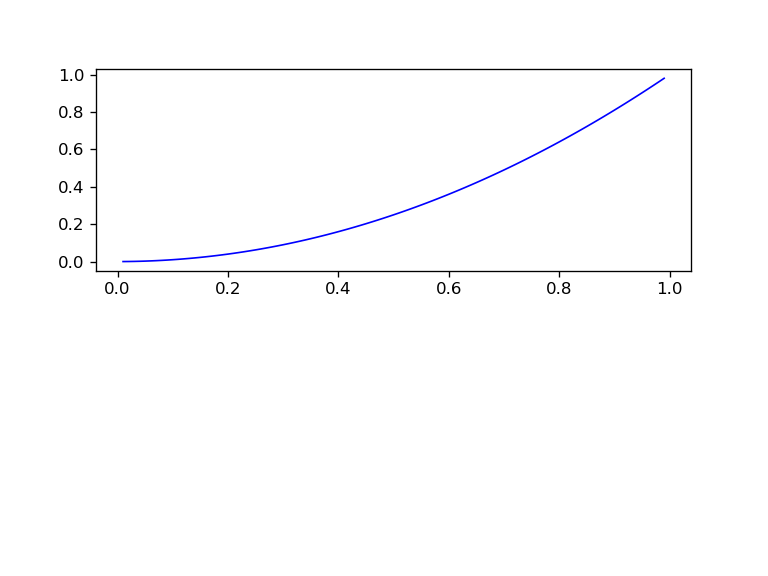

In [81]:
plt.subplot(2,1,1)
dt = 0.01
p = np.arange(dt, 1, dt)
alpha = -slope
pw = (alpha-2)/(alpha-1)
w = np.power(p,pw)
plt.plot(p , w, color='blue', lw=1)
plt.show()

The linear regression is not a good fit because by noise data or any Lasso or Ridge penalty needed. 
Lets check from the data is the top 20% of users with largest number of locations visited have visited the 80% of the locations.

In [9]:
locs_ids = table[table.user.isin(user_locations.iloc[:21700].index)]['location id']

In [10]:
print ("percentage of locations visited by top 20% is",round(100*len(locs_ids.unique())/1280969, 2))
print("Our problem has a 80-20 rule")

percentage of locations visited by top 20% is 80.0
Our problem has a 80-20 rule


# Highest scores algorithm 

We use the records for the top 20% users and ignore the records for places that just appear 1 time.
We sve the reduced table `reduced_data.csv` to use later.

In [125]:
cut_table = table[table.user.isin(user_locations.iloc[:21700].index)]
locs_1 = cut_table['location id'].value_counts()
locs_1 = locs_1[locs_1==1]
cut_table = cut_table[~cut_table['location id'].isin(locs_1.index)]
cut_table['check-in time'] = pd.to_datetime(cut_table['check-in time'])

ids = tuple(cut_table.user.unique())

In [127]:
# Save the table with reduced records
#cut_table.to_csv('reduced_data.csv', index=False)

In [ ]:
# Code to calculate scores
L = len(ids)
L = 10
for i in range(L-1):
    s_table = cut_table[cut_table.user==i]
    for j in range(i+1, L):
        t_table = cut_table[cut_table.user==j]
        share = set(s_table['location id']).intersection(t_table['location id'])
        print('share', len(share))
        st, ts = 0, 0
        for i in share:
            time1 = s_table[s_table['location id']==i]['check-in time'].max()
            time2 = t_table[t_table['location id']==i]['check-in time'].min()
            if time2 < time1:
                #print('st', 1)
                st += 1
            if time2 > time1:
                #print('ts', 1)
                ts += 1
        print(i, j, st, ts)

## Friends scores

To do this we are going to take the friends pairs from the edges table. Before that, we should transform the edges to unique edges list with `networkx`.

- create script to calculate scores for friends.

In [15]:
unique_edges = list(edges.apply(lambda x: (x[0], x[1]), axis=1))

In [16]:
import networkx as nx
G=nx.Graph()
G.add_edges_from(unique_edges)

In [80]:
print(G.number_of_edges())

950327


Now, save the graph object and cut_table to pickle files.
These shorter files reduce the computing time.

In [25]:
import pickle
# Save Pickle
pickling_on = open("edges.pickle","wb")
pickle.dump(G, pickling_on)
pickling_on.close()
cut_table.to_pickle('reduced_data.pickle')

In [33]:
# read pickle edges file
pickle_off = open("reduced_data.pickle","rb")
emp = pickle.load(pickle_off)

We are going to use `multiprocessing` for parallel computing in the script `firends_score_mp.py`, which 
has an expected computation time of 133 min. 



## No-friends score

- Create edges file of no-firends from friends edges and reduced check-ins table.
- Evaluate the score for no-friends.